<a href="https://colab.research.google.com/github/boxcounter/exercises_for_ai_principle_beginner_course/blob/main/lesson08/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda
Shape: X = torch.Size([100, 2]), y = torch.Size([100, 1])
Test set: average loss: 0.0022, accuracy: 60.0%
Test set: average loss: 0.0007, accuracy: 96.0%
Test set: average loss: 0.0005, accuracy: 98.0%
Test set: average loss: 0.0004, accuracy: 99.0%
Test set: average loss: 0.0004, accuracy: 99.0%
Test set: average loss: 0.0004, accuracy: 100.0%
Test set: average loss: 0.0003, accuracy: 100.0%
Test set: average loss: 0.0003, accuracy: 100.0%
Test set: average loss: 0.0003, accuracy: 100.0%
Test set: average loss: 0.0003, accuracy: 100.0%
Test set: average loss: 0.0003, accuracy: 100.0%
Test set: average loss: 0.0002, accuracy: 100.0%
Test set: average loss: 0.0002, accuracy: 100.0%
Test set: average loss: 0.0002, accuracy: 100.0%
Test set: average loss: 0.0002, accuracy: 100.0%
Test set: average loss: 0.0002, accuracy: 100.0%
Test set: average loss: 0.0002, accuracy: 100.0%
Test set: average loss: 0.0002, accuracy: 100.0%
Test set: average loss: 0.0002, accuracy: 100.

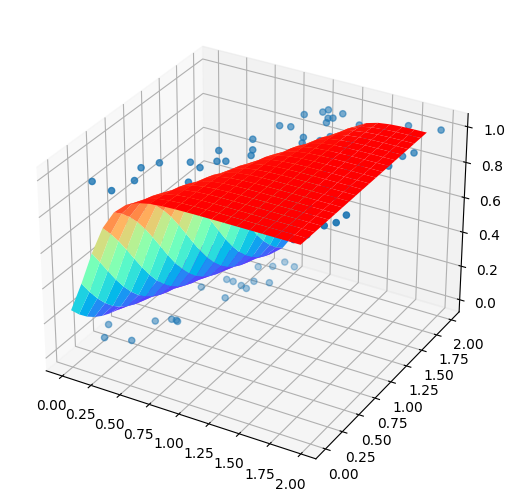

Done. Bye.


SystemExit: ignored

In [3]:
import sys
import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)

def get_beans(counts):
	xs = np.random.rand(counts,2)*2
	ys = np.zeros(counts)
	for i in range(counts):
		x = xs[i]
		if (x[0]-0.5*x[1]-0.1)>0:
			ys[i] = 1
	return xs,ys

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequntial = nn.Sequential(
            nn.Linear(2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.sequntial(x)

def train(X, y, model, loss_func, optimizer):
    model.train()
    y_predict = model(X)
    loss = loss_func(y_predict, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def test(X, y, model, loss_func, debug: bool = False):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        y_predict = model(X)
        test_loss += loss_func(y_predict, y).item()
        correct += (y_predict.round() == y).type(torch.float).sum().item()
    test_loss /= len(X)
    correct /= len(X)

    if debug:
        print(f"Test set: average loss: {test_loss:.4f}, accuracy: {correct:.1%}")

def show_scatter_surface_with_model(X, Y, model):
    x = X.detach().cpu().numpy()[:,0]
    z = X.detach().cpu().numpy()[:,1]
    y = Y.detach().cpu().numpy()

    fig = plt.figure()
    ax = Axes3D(fig, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.scatter(x, z, y)

    x = np.arange(np.min(x), np.max(x), 0.1)
    z = np.arange(np.min(z), np.max(z), 0.1)
    x, z = np.meshgrid(x, z)

    xs = np.column_stack((x[0], z[0]))

    for j in range(z.shape[0]):
        if j == 0:
            continue
        xs = np.vstack((xs, np.column_stack((x[0], z[j]))))

    model.eval()
    y = model(torch.from_numpy(xs).to(device).float())
    y = y.detach().cpu().numpy()
    y = y.reshape(x.shape[0], z.shape[1])
    ax.plot_surface(x, z, y, cmap='rainbow')
    plt.show()

def main():
    print(f"Using device: {device}")

    epochs = 1000
    dataset_size = 100
    X, y = get_beans(dataset_size)
    X = torch.tensor(X, dtype=torch.float).to(device) # a 100*2 vector
    y = torch.tensor(y, dtype=torch.float).reshape(dataset_size, 1).to(device) # a 100*1 vector
    print(f"Shape: X = {X.shape}, y = {y.shape}")

    model = NeuralNetwork().to(device)
    loss_func = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    for epoch in range(epochs):
        train(X, y, model, loss_func, optimizer)
        test(X, y, model, loss_func, debug = (epoch % 50 == 0))
    
    show_scatter_surface_with_model(X, y, model)

    print("Done. Bye.")
    return 0

if __name__ == '__main__':
    sys.exit(main())